## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out.mzTab
  - metadata.sdrf.tsv or experimental_design.tsv 

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
# preprocess out_msstats.csv

import pandas as pd

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro:
        t = []
        for p in Pro.split(";"):
            if "CONTAMINANT" in p or "DECOY_" in p:
                pass
            else:
                t.append(p)
        return ";".join(t)
    else:
        return Pro
    
data = pd.read_csv("../datasets/PXD014414/out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
data.to_csv("../datasets/PXD014414/out_msstats_pre.csv", index=False, sep=",")

In [3]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = '../datasets/PXD014414'
setwd(data_folder)
openms_output = './out_msstats_pre.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

INFO  [2021-09-11 20:25:28] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-11 20:25:29] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-11 20:25:29] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-11 20:25:29] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-11 20:25:29] ** Shared peptides are removed.
INFO  [2021-09-11 20:25:29] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-11 20:25:33] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-11 20:25:33] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-09-11 20:25:34] ** For peptides overl

### Protein summarization, normalization and visualization

INFO  [2021-09-11 20:25:40] ** MSstatsTMT - proteinSummarization function
INFO  [2021-09-11 20:25:41] Summarizing for Run : 2_2_2 ( 1  of  3 )
  |======================================================================| 100%
INFO  [2021-09-11 20:25:58] Summarizing for Run : 3_3_3 ( 2  of  3 )
  |======================================================================| 100%
INFO  [2021-09-11 20:26:16] Summarizing for Run : 1_1_1 ( 3  of  3 )
  |======================================================================| 100%
INFO  [2021-09-11 20:26:32] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


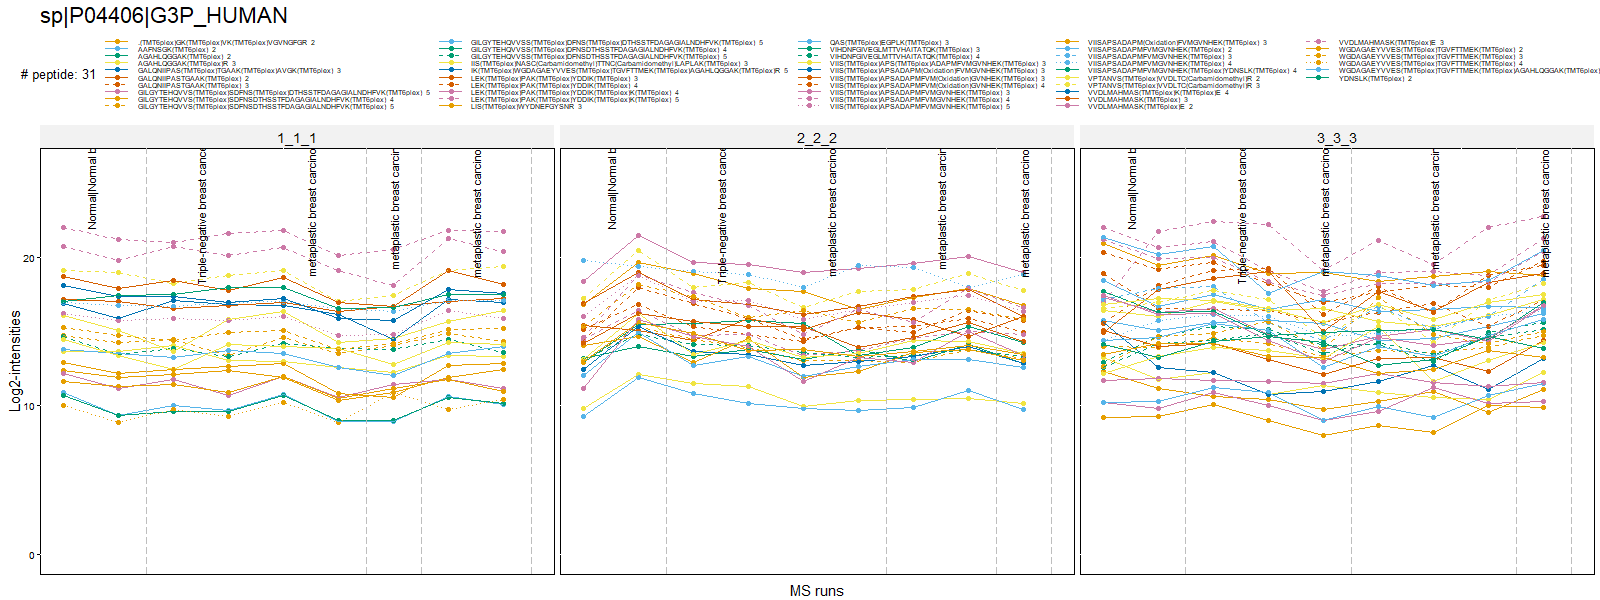

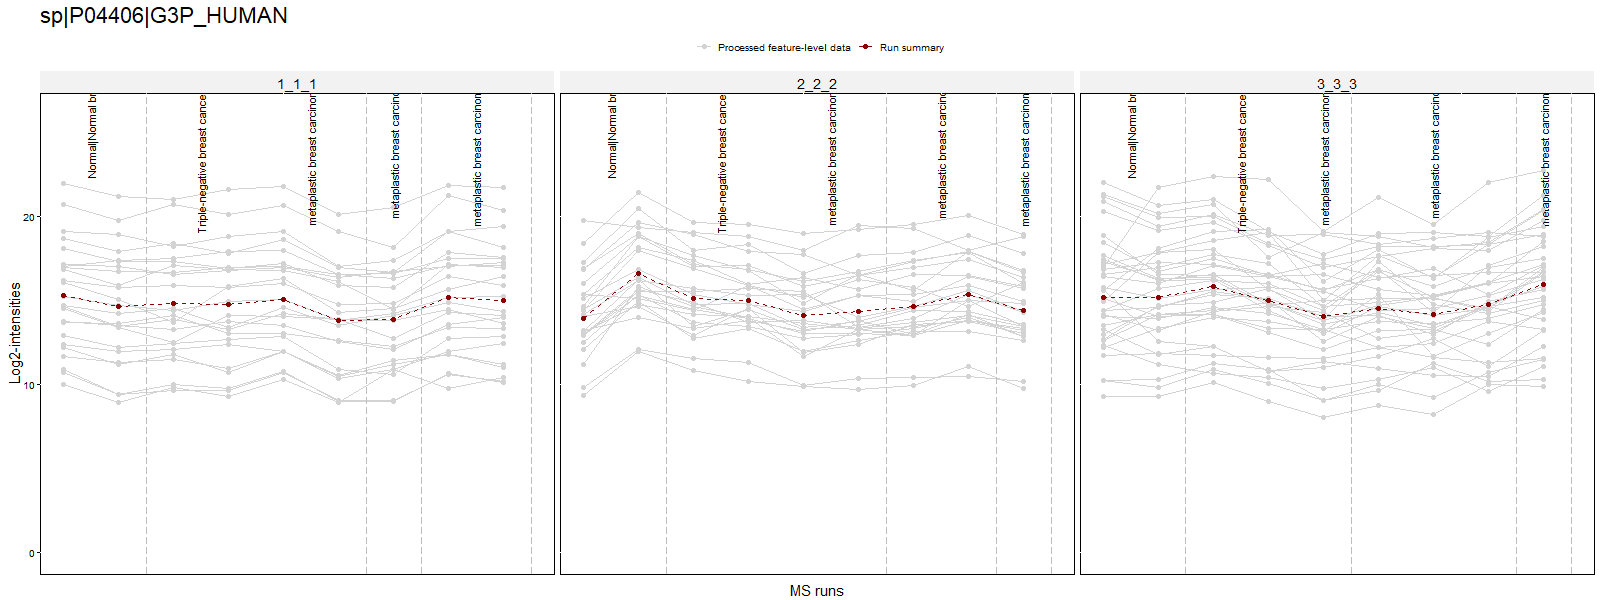

In [4]:
%%R -w 1600 -h 600

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P04406|G3P_HUMAN',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



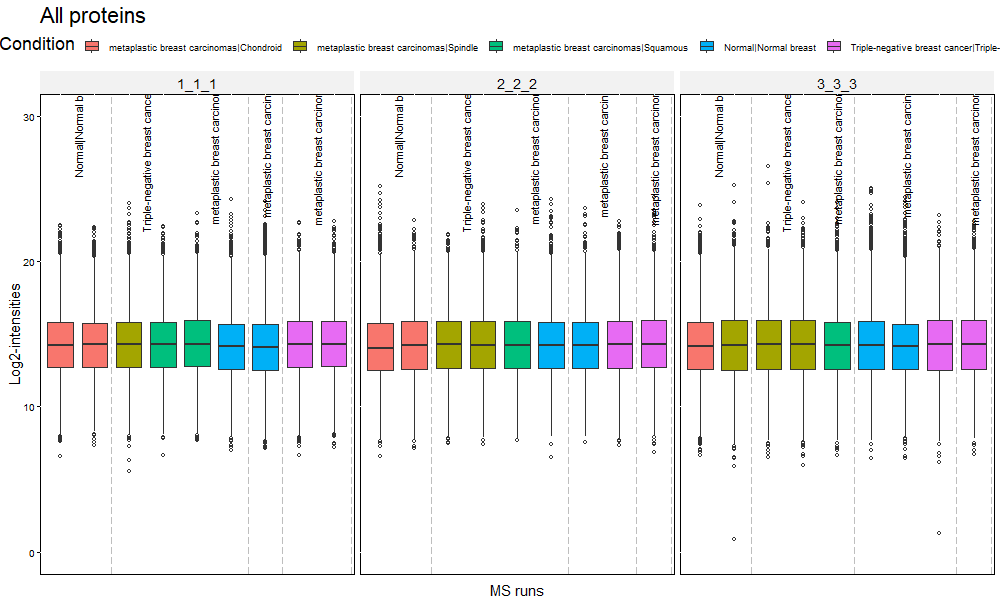

In [5]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [6]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "metaplastic breast carcinomas|Chondroid"      
[2] "metaplastic breast carcinomas|Spindle"        
[3] "metaplastic breast carcinomas|Squamous"       
[4] "Normal|Normal breast"                         
[5] "Triple-negative breast cancer|Triple-negative"


In [7]:
%%R -w 1000 -h 600

Cancer_Normal_Comp<-matrix(c(0,0,1,0,1,0,0,0,0,1,0,0,-1,-1,-1,-1,0,0,0,1),nrow=4)
row.names(Cancer_Normal_Comp)<-c("MBC Spindle vs Normal", "MBC Squamous vs Normal", "MBC Sarcomatoid vs Normal", "TNBC vs Normal")
colnames(Cancer_Normal_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Cancer_Normal_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cancer_Normal_Comp, moderated = TRUE)

INFO  [2021-09-11 20:27:18] Model fitting for 2231 proteins.
  |======================================================================| 100%
INFO  [2021-09-11 20:28:34] Testing for 2231 proteins:
  |======================================================================| 100%


In [8]:
%%R

head(Cancer_Normal_Comp.pairwise$ComparisonResult)

                     Protein                     Label     log2FC        SE
1:  sp|A0A075B6H7|KV37_HUMAN     MBC Spindle vs Normal -3.0040996 1.4580908
2:  sp|A0A075B6H7|KV37_HUMAN    MBC Squamous vs Normal -1.3437486 1.1905261
3:  sp|A0A075B6H7|KV37_HUMAN MBC Sarcomatoid vs Normal -3.2006262 1.1905261
4:  sp|A0A075B6H7|KV37_HUMAN            TNBC vs Normal -2.3966026 1.1905261
5: sp|A0A075B6S5|KV127_HUMAN     MBC Spindle vs Normal -0.1312968 0.5505332
6: sp|A0A075B6S5|KV127_HUMAN    MBC Squamous vs Normal -0.6786730 0.7107353
          DF     pvalue adj.pvalue issue
1:  9.174013 0.06885936  0.2101069  <NA>
2:  9.174013 0.28767395  0.5360398  <NA>
3:  9.174013 0.02445837  0.3248217  <NA>
4:  9.174013 0.07435880  0.2099513  <NA>
5: 18.174013 0.81416925  0.9056132  <NA>
6: 18.174013 0.35216386  0.5947837  <NA>


#### Visualization Cancer vs Normal Condition (Corresponding Supplementary figure3 B)

In [9]:
%%R

Cancer_Normal_Comp = Cancer_Normal_Comp.pairwise$ComparisonResult
write.table(Cancer_Normal_Comp,"Cancer_Normal_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

In [10]:
# map protein to gene name
import re
import urllib.parse
import urllib.request

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        r = {}
        keys = re.split('\t|\n', data)[::2][1:-1]
        values = re.split('\t|\n', data)[1::2][1:]
        for i in range(len(keys)):
            if keys[i] in r:
                r[keys[i]] = r[keys[i]] + "/" + values[i]
            else:
                r[keys[i]] = values[i]     
    return r

                     Protein                      Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN      MBC Spindle vs Normal -3.004100  0.068859   
1   sp|A0A075B6H7|KV37_HUMAN     MBC Squamous vs Normal -1.343749  0.287674   
2   sp|A0A075B6H7|KV37_HUMAN  MBC Sarcomatoid vs Normal -3.200626  0.024458   
3   sp|A0A075B6H7|KV37_HUMAN             TNBC vs Normal -2.396603  0.074359   
4  sp|A0A075B6S5|KV127_HUMAN      MBC Spindle vs Normal -0.131297  0.814169   

   -Log10(p-value)     group  
0         1.162037   dimgrey  
1         0.541099   dimgrey  
2         1.611573  tab:blue  
3         1.128668   dimgrey  
4         0.089285   dimgrey  


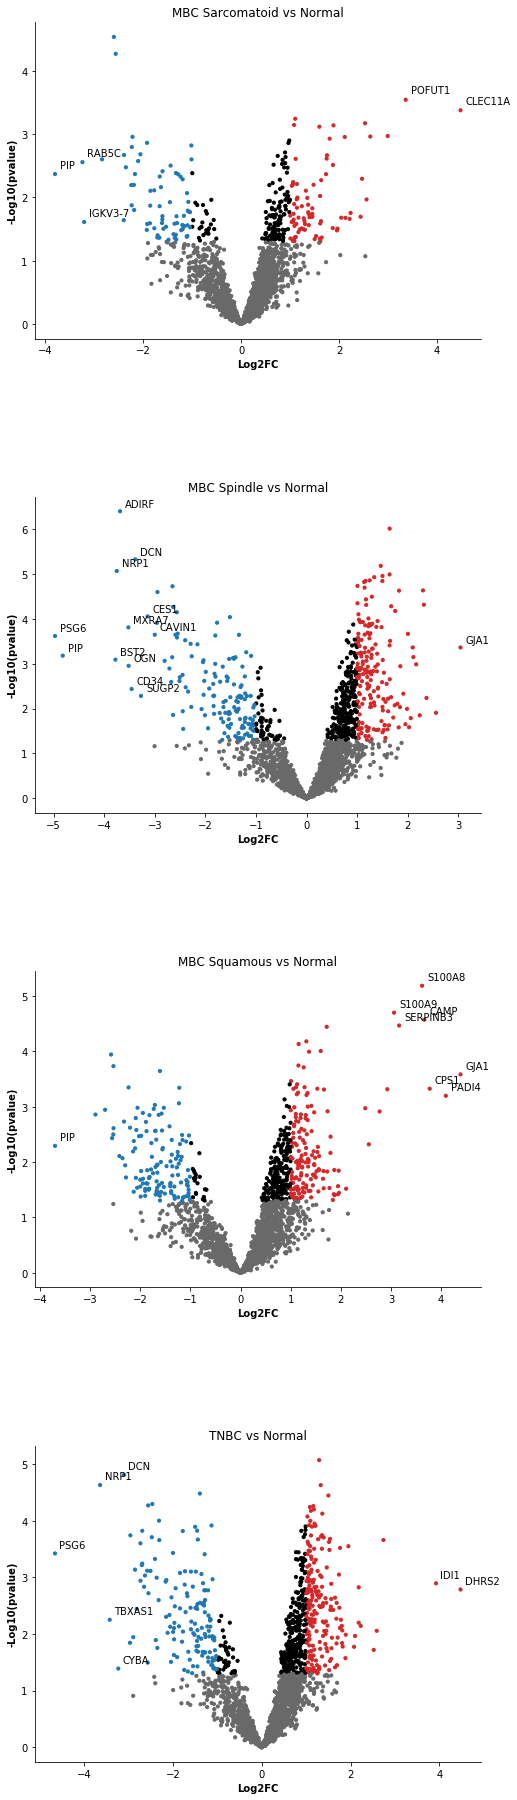

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt


def preprocess(s):
    return s.split('|')[-1]

result = pd.read_csv('./Cancer_Normal_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

#### Comparing the top 10 most significant changed proteins with the article


####  In terms of MBC Sarcomatoid subtype, the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 1. Three of these proteins are included in our quantitative protein and one of these proteins are included in our upRegulated proteins.  The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 0. Three of these proteins are included in our quantitative protein.

#### In terms of MBC Spindle subtype, the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 0. Three of these proteins are included in our upRegulated proteins. The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 0. Four of these proteins are included in our quantitative protein and three of these proteins  are included in our downRegulated protein.

#### In terms of MBC Squamous subtype, the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 0. Three of these proteins are included in our quantitative proteins. The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 1. Five of these proteins are included in our quantitative protein and three of these proteins are included in our downRegulated protein.

#### In terms of TNBC,  the intersection of the top 10 most significant upRegulated proteins given in the article with our top 10 most significant upRegulated proteins is 1. Four of these proteins are included in our quantitative proteins. The intersection of the top 10 most significant downRegulated proteins given in the article with our top 10 most significant downRegulated proteins is 0. Four of these proteins are included in our quantitative protein and three of these proteins are included in our downRegulated protein.

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Sarcomatoid vs Normal DownRegulated proteins: 69
MBC Sarcomatoid vs Normal UpRegulated proteins: 78
The top 10 most significant upRegulated proteins in MBC Sarcomatoid vs Normal : CLEC11A,POFUT1,TOMM6,SNRNP27,SERPINE2,REXO4,TRIM2,STRN,ZNF280D,SMG8
The top 10 most significant downRegulated proteins in MBC Sarcomatoid vs Normal : CES1,MLF2,NDE1,RAB5B,DES,FHL1,ERC2,IGKV3-7,RAB5C,PIP


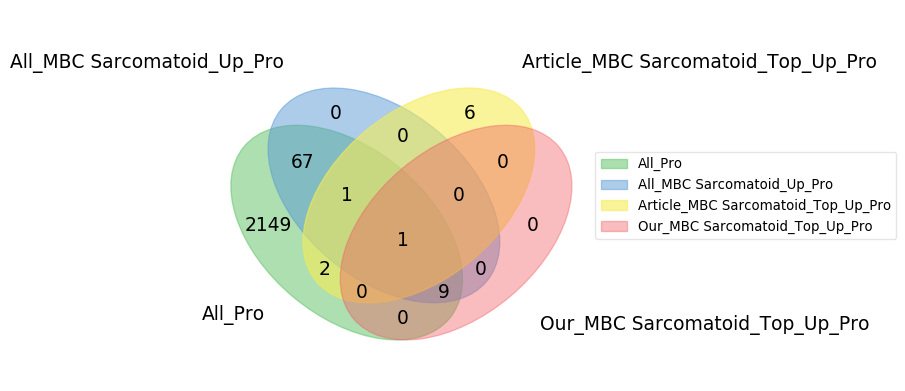

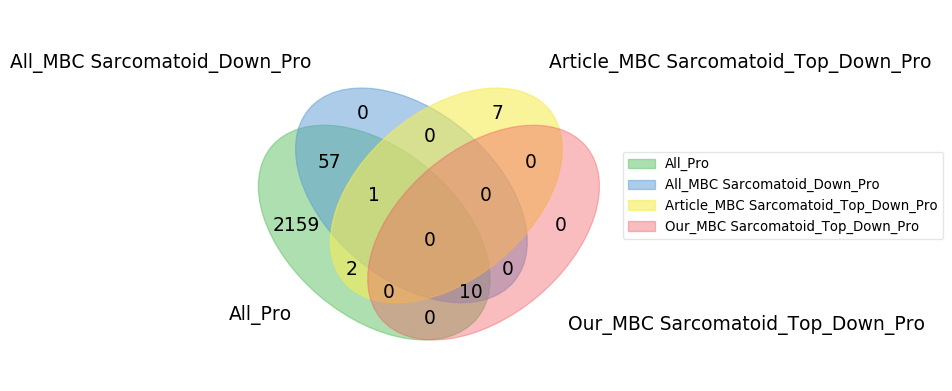

The shared upRegulated proteins: UQCRH,PCLAF,SNRNP27,ARFGEF2
The shared downRegulated proteins: KANK2,HNMT,GNB1


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Spindle vs Normal DownRegulated proteins: 138
MBC Spindle vs Normal UpRegulated proteins: 181
The top 10 most significant upRegulated proteins in MBC Spindle vs Normal : GJA1,TRIM2,RPL22,NUCKS1,PLOD1,XPO4,SNRNP27,CTHRC1,HSP90AB4P,IGF2BP2
The top 10 most significant downRegulated proteins in MBC Spindle vs Normal : SUGP2,DCN,CD34,OGN,MXRA7,ADIRF,NRP1,BST2,PIP,PSG6


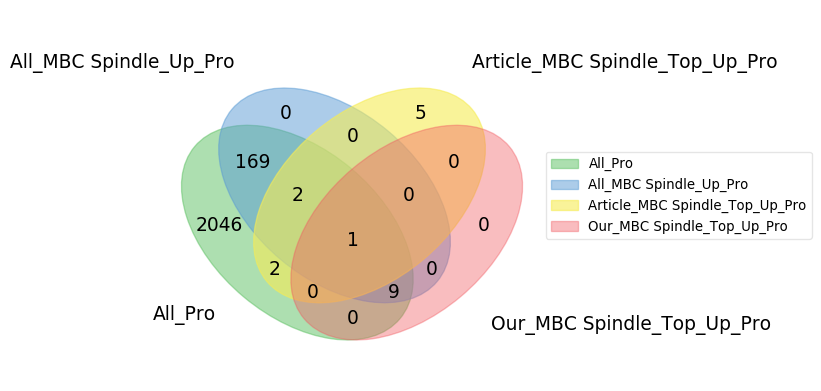

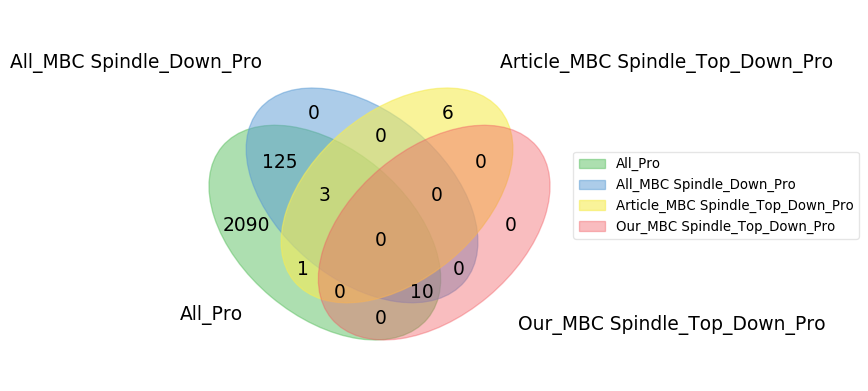

The shared upRegulated proteins: MSL1,CNN2,PDIA4,PLOD1,RPL28
The shared downRegulated proteins: LILRB5,CFD,CLEC3B,MYH11


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


MBC Squamous vs Normal DownRegulated proteins: 127
MBC Squamous vs Normal UpRegulated proteins: 158
The top 10 most significant upRegulated proteins in MBC Squamous vs Normal : GJA1,PADI4,CPS1,CAMP,S100A8,SERPINB3,S100A9,S100A7,LACTBL1,ZCCHC12
The top 10 most significant downRegulated proteins in MBC Squamous vs Normal : AOC3,PLIN4,CES1,CFD,NOTCH2,FBN2,AZGP1,DDRGK1,GPR180,PIP


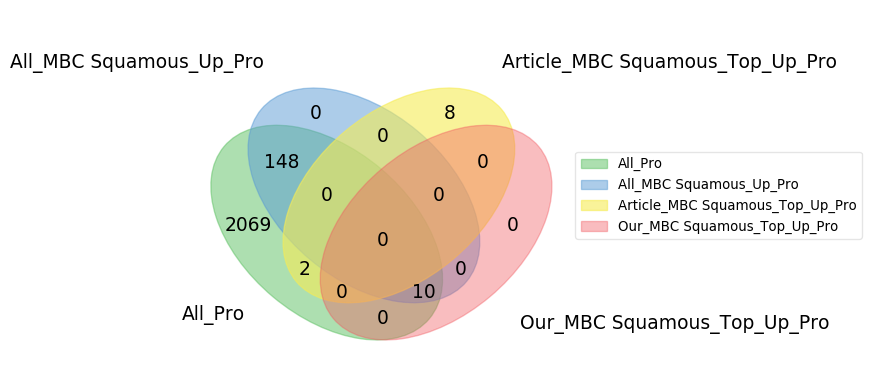

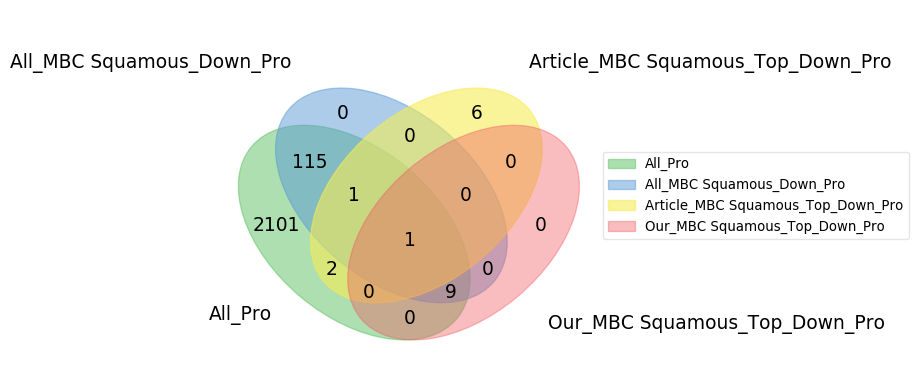

The shared upRegulated proteins: CNN2,LSP1
The shared downRegulated proteins: MAMDC2,CFD,AKAP12,DCN


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


TNBC vs Normal DownRegulated proteins: 141
TNBC vs Normal UpRegulated proteins: 203
The top 10 most significant upRegulated proteins in TNBC vs Normal : DHRS2,IDI1,SNRNP27,MDK,NUP210,IVNS1ABP,TRIR,PUS1,NCBP1,WIZ
The top 10 most significant downRegulated proteins in TNBC vs Normal : OGN,FABP4,ETV6,CES1,SUGP2,DCN,CYBA,TBXAS1,NRP1,PSG6


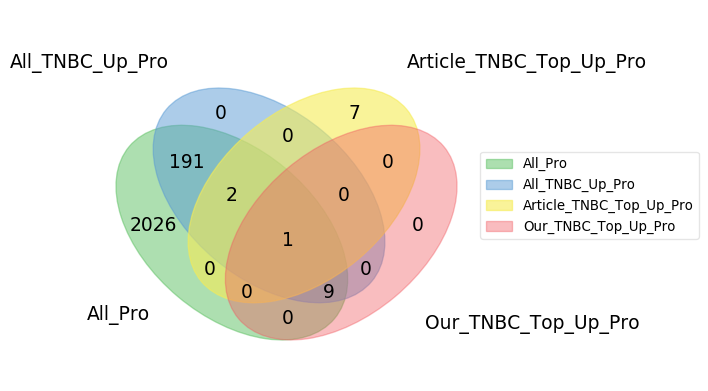

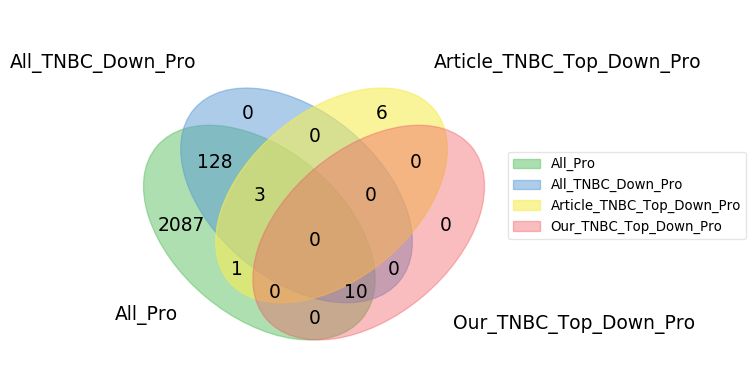

The shared upRegulated proteins: STMN1,THBS1,SNRNP27
The shared downRegulated proteins: CFD,PLTP,DES,TNXB


In [13]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from pyvenn import venn

result = pd.read_csv('./Cancer_Normal_Comp_result.csv', sep=',')

def preprocess(s):
    return s.split('|')[-1]

Article_Top_Up_Pro = {"TNBC vs Normal": ['HMGA1', 'RREB1', 'THBS1', 'ESPN', 'HAT1', 'APC', 'FOXP4', 'GPRC5A', 'SNRNP27', 'STMN1'],
                     "MBC Spindle vs Normal": ['RPS28', 'PLOD1', 'CALU', 'PDIA4', 'RPL28', 'CNN2', 'HIST3H2BB', 'RPL39', 'SDC2', 'MSL1'],
                     "MBC Squamous vs Normal": ['ZCCHC17', 'KRT5', 'SNUPN', 'CNN2', 'FOSL2', 'LSP1', 'SASH3', 'TMEM70', 'TLDC1', 'PAIP2'],
                     "MBC Sarcomatoid vs Normal": ['ARFGEF2', 'PCLAF', 'PTX3', 'TMEM230', 'TAF6L', 'UQCRH', 'SNRNP27', 'RREB1', 'MLLT1', 
                                                   'GOLT1B']}

Article_Top_Down_Pro = {"TNBC vs Normal": ['FCGRT', 'ADH1B', 'SHMT1', 'STAB1', 'PLTP', 'DES', 'CFD', 'IGLV211', 'IGHG1', 'TNXB'],
                       "MBC Spindle vs Normal": ['ARRDC5', 'IDO1', 'LTBP4', 'SHMT1', 'CLEC3B', 'CFD', 'CPA3', 'MYH11', 'LILRB5', 'PODN'],
                        "MBC Squamous vs Normal": ['HSPB6', 'PEX12', 'AKAP12', 'DCN', 'CFD', 'DPT', 'IGLV211', 'SERPINC1', 'MAMDC2', 'GPT'],
                       "MBC Sarcomatoid vs Normal": ['CDH5', 'FADD', 'CAP2', 'MSRA', 'GNB1', 'CD99', 'STAB1', 'KANK2', 'HNMT', 'CPM']}

for comp in np.unique(result['Label']):
    t = result[result["Label"] == comp]
    t_All = t['Protein'].tolist()
    t_All_Pro = MapProtGeneName(list(map(preprocess, t_All))).values()

    t_Up = t[(t['log2FC'] > 1)&(t['pvalue'] < 0.05)]
    t_Down = t[(result['log2FC'] < -1)&(t['pvalue'] < 0.05)]
    print(comp + " DownRegulated proteins: %d" %(len(set(t_Down['Protein']))))
    print(comp + " UpRegulated proteins: %d" %(len(set(t_Up['Protein']))))

    # ALL the differential changed proteins
    ALL_t_Up_Pro  = MapProtGeneName(list(map(preprocess, t_Up['Protein'].tolist()))).values()
    ALL_t_Down_Pro = MapProtGeneName(list(map(preprocess, t_Down['Protein'].tolist()))).values()

    # The list of the top 10 most significant up- and downregulated proteins are given in the article.
    Article_t_Top_Down_Pro = Article_Top_Down_Pro[comp]
    Article_t_Top_Up_Pro = Article_Top_Up_Pro[comp]

    # UpRegulated proteins top 10
    Our_t_Top_Up_Pro = MapProtGeneName(list(map(preprocess, t_Up.sort_values(["log2FC"],ascending=False).head(10)['Protein'].tolist()))).values()
    print("The top 10 most significant upRegulated proteins in " + comp + " : " + ",".join(Our_t_Top_Up_Pro))

    # top 10 downRegulated protein 
    Our_t_Top_Down_Pro = MapProtGeneName(list(map(preprocess, t_Down.sort_values(["log2FC"],ascending=False).tail(10)['Protein'].tolist()))).values()
    print("The top 10 most significant downRegulated proteins in " + comp + " : " + ",".join(Our_t_Top_Down_Pro))

    labels = venn.get_labels([set(t_All_Pro), set(ALL_t_Up_Pro), set(Article_t_Top_Up_Pro), set(Our_t_Top_Up_Pro)], fill=['number'])
    fig, ax = venn.venn4(labels, names=['All_Pro', 'All_' + comp.replace(" vs Normal", '') + '_Up_Pro', 'Article_' + comp.replace(" vs Normal", '') + '_Top_Up_Pro', 'Our_' 
                                         + comp.replace(" vs Normal", '') + '_Top_Up_Pro'], figsize=(5, 10))
    plt.show()
    
    labels = venn.get_labels([set(t_All_Pro), set(ALL_t_Down_Pro), set(Article_t_Top_Down_Pro), set(Our_t_Top_Down_Pro)], fill=['number'])
    fig, ax = venn.venn4(labels, names=['All_Pro', 'All_' + comp.replace(" vs Normal", '') + '_Down_Pro', 'Article_' + comp.replace(" vs Normal", '') + '_Top_Down_Pro', 'Our_' 
                                         + comp.replace(" vs Normal", '') + '_Top_Down_Pro'], figsize=(5, 10))
    plt.show()
    
    print("The shared upRegulated proteins: " + ",".join(set(t_All_Pro).intersection(set(Article_t_Top_Up_Pro))))
    print("The shared downRegulated proteins: " + ",".join(set(t_All_Pro).intersection(set(Article_t_Top_Down_Pro))))

#### Volcano plots comparing MBC with TNBC and within MBC subtype (Corresponding figure 3 B)

#### Compared with the original picture, the overlapping part of the differential protein is too small. But we found more and more significant difference proteins

In [14]:
%%R -w 1000 -h 600

Within_Subtype_Comp<-matrix(c(-1,-1,0,0,1,1,1,0,-1,0,0,0,0,0,0),nrow=3)
row.names(Within_Subtype_Comp)<-c("SQUAMOUS vs SARCOMATOID", "SPINDLE vs SARCOMATOID", "SPINDLE vs SQUAMOUS")
colnames(Within_Subtype_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Within_Subtype_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Within_Subtype_Comp, moderated = TRUE)

Within_Subtype_Comp['SQUAMOUS vs SARCOMATOID',]

INFO  [2021-09-11 20:35:23] Model fitting for 2231 proteins.
  |======================================================================| 100%
INFO  [2021-09-11 20:36:37] Testing for 2231 proteins:
  |======================================================================| 100%
      metaplastic breast carcinomas|Chondroid 
                                           -1 
        metaplastic breast carcinomas|Spindle 
                                            0 
       metaplastic breast carcinomas|Squamous 
                                            1 
                         Normal|Normal breast 
                                            0 
Triple-negative breast cancer|Triple-negative 
                                            0 


In [15]:
%%R

Within_Subtype_Comp = Within_Subtype_Comp.pairwise$ComparisonResult
write.table(Within_Subtype_Comp,"Within_Subtype_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                     Protein                    Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  SQUAMOUS vs SARCOMATOID  1.856878  0.152621   
1   sp|A0A075B6H7|KV37_HUMAN   SPINDLE vs SARCOMATOID  0.196527  0.895694   
2   sp|A0A075B6H7|KV37_HUMAN      SPINDLE vs SQUAMOUS -1.660351  0.283683   
3  sp|A0A075B6S5|KV127_HUMAN  SQUAMOUS vs SARCOMATOID -0.450137  0.555367   
4  sp|A0A075B6S5|KV127_HUMAN   SPINDLE vs SARCOMATOID  0.097239  0.872906   

   -Log10(p-value)    group  
0         0.816386  dimgrey  
1         0.047840  dimgrey  
2         0.547167  dimgrey  
3         0.255420  dimgrey  
4         0.059033  dimgrey  


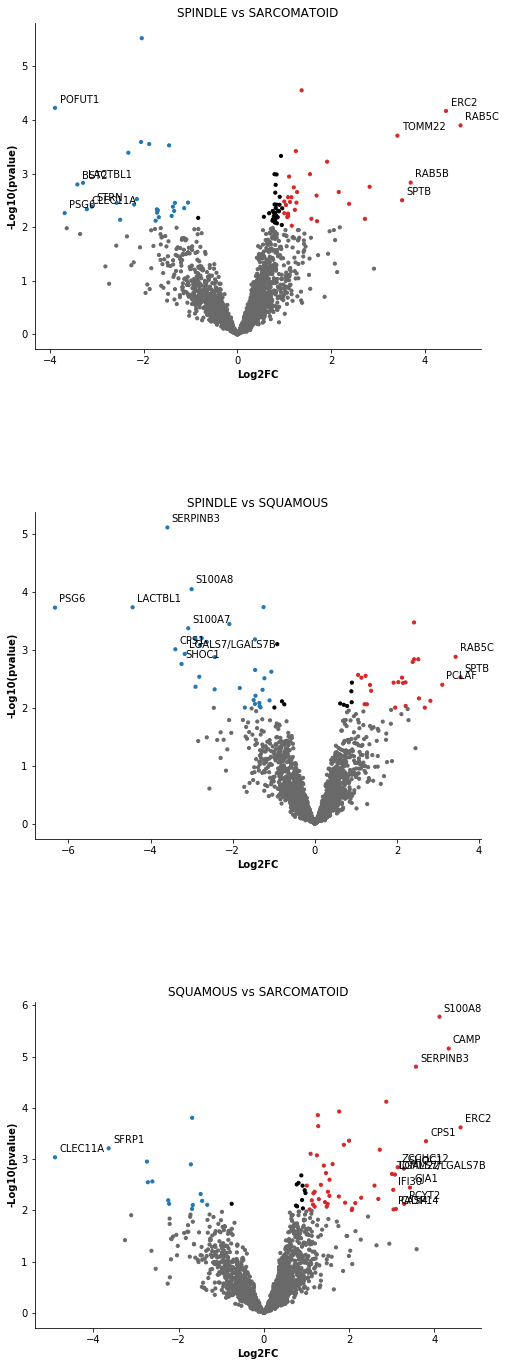

In [16]:
result = pd.read_csv('./Within_Subtype_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.01,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 24))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


In [17]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats_pre.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

raw.om$Condition[which(raw.om$Condition == "metaplastic breast carcinomas|Chondroid"|raw.om$Condition=="metaplastic breast carcinomas|Spindle"|raw.om$Condition=="metaplastic breast carcinomas|Squamous")] <- "MBC"
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

print(levels(quant_om.msstats$ProteinLevelData$Condition))


INFO  [2021-09-11 20:38:52] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-11 20:38:52] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-11 20:38:53] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-11 20:38:53] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-11 20:38:53] ** Shared peptides are removed.
INFO  [2021-09-11 20:38:53] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-11 20:38:56] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-11 20:38:57] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-09-11 20:38:58] ** For peptides overl

In [18]:
%%R

MBC_TNBC_Comp<-matrix(c(1,0,-1),nrow=1)
row.names(MBC_TNBC_Comp)<-c("MBC vs TNBC")
colnames(MBC_TNBC_Comp) = c("MBC","Normal|Normal breast", "Triple-negative breast cancer|Triple-negative")


MBC_TNBC_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = MBC_TNBC_Comp, moderated = TRUE)
MBC_TNBC_Comp = MBC_TNBC_Comp.pairwise$ComparisonResult
write.table(MBC_TNBC_Comp,"MBC_TNBC_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-09-11 20:39:51] Model fitting for 2231 proteins.
  |======================================================================| 100%
INFO  [2021-09-11 20:41:02] Testing for 2231 proteins:
  |======================================================================| 100%


                     Protein        Label    log2FC    pvalue  \
0   sp|A0A075B6H7|KV37_HUMAN  MBC vs TNBC -0.021967  0.983509   
1  sp|A0A075B6S5|KV127_HUMAN  MBC vs TNBC  0.398579  0.408228   
2  sp|A0A0B4J1X5|HV374_HUMAN  MBC vs TNBC  0.106736  0.752837   
3  sp|A0A0C4DH38|HV551_HUMAN  MBC vs TNBC  0.052461  0.853039   
4       sp|A0AVT1|UBA6_HUMAN  MBC vs TNBC -0.338800  0.111011   

   -Log10(p-value)    group  
0         0.007222  dimgrey  
1         0.389097  dimgrey  
2         0.123299  dimgrey  
3         0.069031  dimgrey  
4         0.954635  dimgrey  


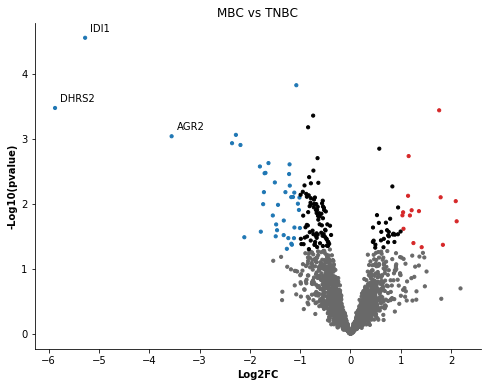

In [19]:
result = pd.read_csv('./MBC_TNBC_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())


fig = plt.figure(figsize=(8, 6))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(110 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### Vislization MBC subtype vs TNBC (Supplementary Figure 7)

#### Compared with the original image, the difference protein has overlapping parts, and we found more difference proteins. The article gives too little difference protein

In [20]:
%%R

openms_output = './out_msstats_pre.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
raw.om$Condition[which(raw.om$Condition == "not applicable|Reference Sample")] <- "Norm"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)


levels(quant_om.msstats$ProteinLevelData$Condition)

INFO  [2021-09-11 20:42:43] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-11 20:42:44] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-11 20:42:44] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-11 20:42:44] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-11 20:42:44] ** Shared peptides are removed.
INFO  [2021-09-11 20:42:44] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-11 20:42:47] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-11 20:42:48] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-09-11 20:42:49] ** For peptides overl

In [21]:
%%R
Subtype_TNBC_Comp<-matrix(c(0,0,1,1,0,0,0,1,0,0,0,0,-1,-1,-1),nrow=3)
row.names(Subtype_TNBC_Comp)<-c("Spindle vs TNBC", "Squamous vs TNBC", "Sarcomatoid vs TNBC")
colnames(Subtype_TNBC_Comp) = c("metaplastic breast carcinomas|Chondroid","metaplastic breast carcinomas|Spindle",
                        "metaplastic breast carcinomas|Squamous","Normal|Normal breast","Triple-negative breast cancer|Triple-negative")


Subtype_TNBC_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Subtype_TNBC_Comp, moderated = TRUE)

print(Subtype_TNBC_Comp)

Subtype_TNBC_Comp = Subtype_TNBC_Comp.pairwise$ComparisonResult
write.table(Subtype_TNBC_Comp,"Subtype_TNBC_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-09-11 20:43:46] Model fitting for 2231 proteins.
  |======================================================================| 100%
INFO  [2021-09-11 20:44:57] Testing for 2231 proteins:
  |======================================================================| 100%
                    metaplastic breast carcinomas|Chondroid
Spindle vs TNBC                                           0
Squamous vs TNBC                                          0
Sarcomatoid vs TNBC                                       1
                    metaplastic breast carcinomas|Spindle
Spindle vs TNBC                                         1
Squamous vs TNBC                                        0
Sarcomatoid vs TNBC                                     0
                    metaplastic breast carcinomas|Squamous Normal|Normal breast
Spindle vs TNBC                                          0                    0
Squamous vs TNBC                                         1                    0
Sarcomatoid 

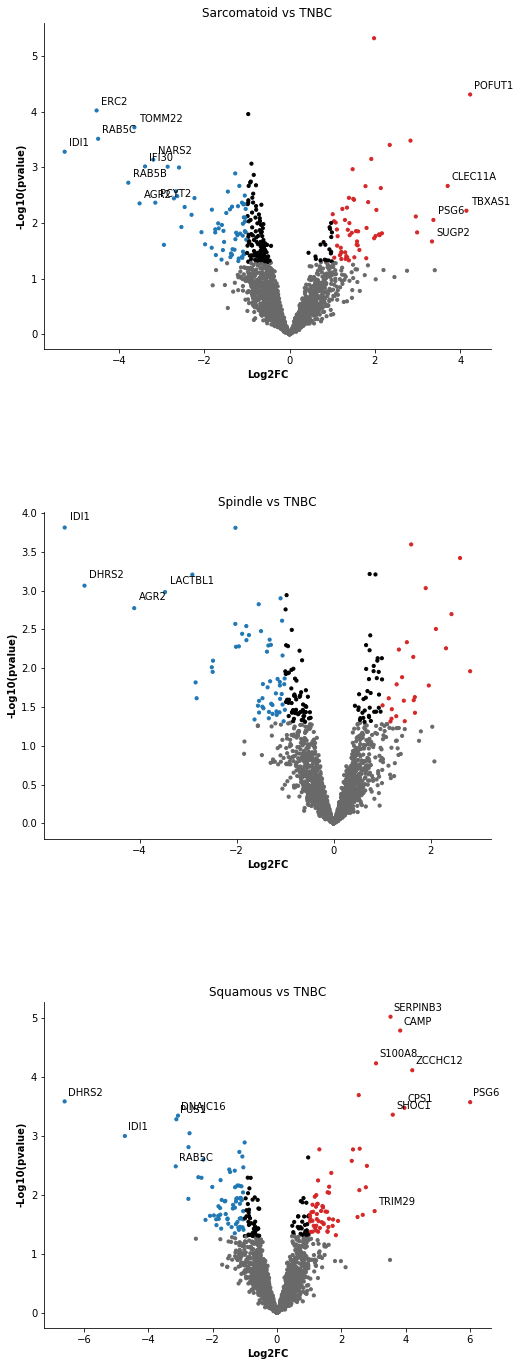

In [22]:
result = pd.read_csv('./Subtype_TNBC_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'


fig = plt.figure(figsize=(8, 24))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))

    for _, row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()



###  Protein expression Heatmaps

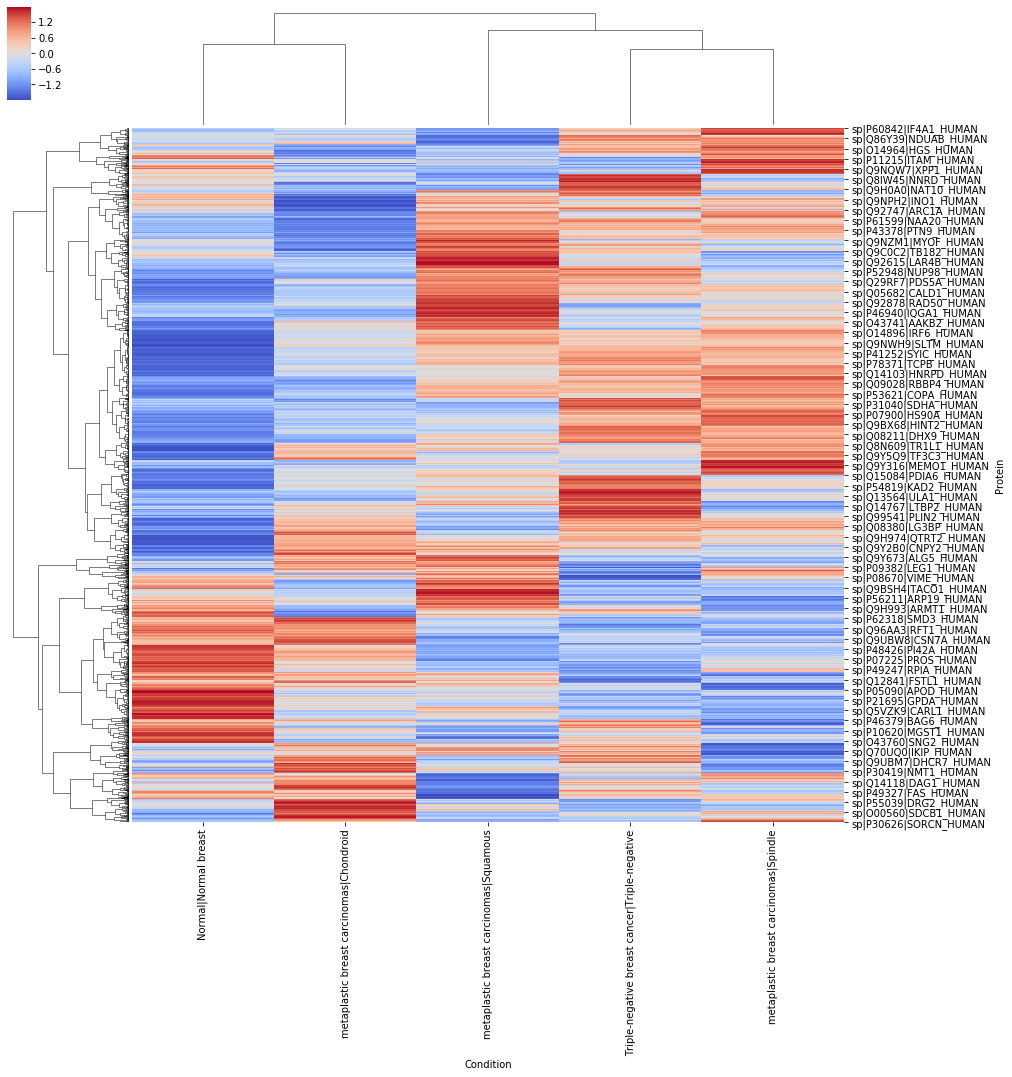

In [23]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = './protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()